# Mount Google drive to store output artefacts

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load the libraries

In [ ]:
from os import listdir
from numpy import asarray
from PIL import Image
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN

# (Helper Function)  Load images from directory as an RGB numpy array

In [ ]:
def load_image(filename):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    return pixels

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
    faces = list()
    for filename in listdir(directory):
        pixels = load_image(directory + filename)
        faces.append(pixels)
        if len(faces) >= n_faces:
            break
    return asarray(faces)

# plot a list of loaded faces
def plot_faces(faces, n):
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(faces[i])
    pyplot.show()

# (Helper Function) Load and extract faces from images

In [ ]:
# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(80, 80)):
    faces = model.detect_faces(pixels)
    # skip cases where we could not detect a face
    if len(faces) == 0:
        return None
    # extract details of the face
    x1, y1, width, height = faces[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face_pixels = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face_pixels)
    image = image.resize(required_size)
    face_array = asarray(image)
    
    return face_array

def load_faces(directory, n_faces, start=0):
    if (start > n_faces):
        print("start is more than n_faces... exiting")
        return
    # prepare model
    model = MTCNN()
    faces = list()
    face_count = start
    print("Loading faces, counter {}".format(face_count))
    
    file_list = listdir(directory)
    file_list.sort()

    # for filename in file_list:
    for ptr in range(start, n_faces+start):
        # load the image
        filename = file_list[ptr]
        pixels = load_image(directory + filename)
        # get face
        face = extract_face(model, pixels)
        if face is None:
            continue
        # store
        faces.append(face)
        face_count += 1
        if (face_count % 10 == 0):
            print("{} faces loaded".format(len(faces)), end='\r')

        #save output to npz for every 10000 face images
        if (face_count % 10000 == 0):
            print('\n')
            filename = 'img_align_celeba_%03d' % (face_count)
            print("Saving the faces into npz file")
            savez_compressed(filename, faces)

        # stop once we have enough
        if face_count >= n_faces:
            break
    return asarray(faces)

# Execute loading of images, extracting faces and storing them as numpy arrays

Images are stored as .npz files at every 10,000 processed images. 
After this is done, the .npz files are combined as one big .npz file

In [ ]:
# directory that contains all images
directory = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'

all_faces = load_faces(directory, 50000)
print('Loaded: ', all_faces.shape)
plot_faces(faces, 5)
print("Saving the faces into npz file")
savez_compressed('img_align_celeba.npz', all_faces)

In [ ]:
from numpy import load

data1 = load('./data/img_align_celeba_10000.npz')['arr_0']
data2 = load('./data/img_align_celeba_20000.npz')['arr_0']
data3 = load('./data/img_align_celeba_30000.npz')['arr_0']
data4 = load('./data/img_align_celeba_40000.npz')['arr_0']
data5 = load('./data/img_align_celeba_50000.npz')['arr_0']

output = np.concatenate([data1, data2, data3, data4, data5])
output.shape
savez_compressed('img_align_celeba.npz', output)

# Define and train the GAN model

In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

## Define the Discriminator and Generator

In [ ]:
def define_discriminator(in_shape=(80,80,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 40x40
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 20x30
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 10x10
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 5x5
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def define_generator(latent_dim):
    model = Sequential()
    # foundation for 5x5 feature maps
    n_nodes = 128 * 5 * 5
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 5, 128)))
    # upsample to 10x10
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 20x20
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 40x40
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 80x80
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer 80x80x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

## Define the GAN model

In [ ]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')
    return model

## Prepare for model training

In [ ]:
# load and prepare training images
def load_real_samples():
    data = load('/kaggle/input/compressed-50k-celebfaces/img_align_celeba.npz')
    X = data['arr_0']
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples for evaluation by discriminator
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    # prepare fake examples for evaluation by discriminator
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)

    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

# Model training

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss, g_acc = gan_model.train_on_batch(X_gan, y_gan)
            
            print('>%d, %d/%d, Discriminator: accuracy1=%.3f, accuracy2=%.3f Generator: accuracy=%.3f' %
                (i+1, j+1, bat_per_epo, d_acc1, d_acc2, g_acc))

        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)

dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

# Load and make inferance from model

In [1]:
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
import shutil

In [2]:
filename = 'generator_model.h5'
# shutil.copy('/content/drive/MyDrive/Colab Notebooks/GAN/Celebfaces/' + filename, '.')

In [3]:
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  return z_input

def plot_generated(examples, n):
  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i])
    pyplot.savefig("generated_faces_plot.jpg")
  pyplot.show()
  pyplot.close()

2021-09-19 02:09:54.672177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-19 02:09:55.561896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


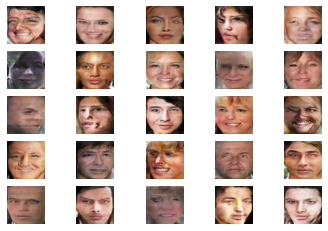

In [5]:
model = load_model('generator_model_100.h5')
latent_points = generate_latent_points(100, 25)
X  = model.predict(latent_points)
X = (X + 1) / 2.0
plot_generated(X, 5)

# Define Frechet Inception Distance (FID) function

In [6]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [7]:
def calculate_fid(images1, images2):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [8]:
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        images_list.append(new_image)
    return asarray(images_list)

In [9]:
def load_images(img_list):
    img_array = []
    for file in img_list:
        img = load_img(file, target_size=(299, 299))
        img = img_to_array(img)
        img_array.append(img)
    img_array = scale_images(img_array, (299,299,3))
    preprocess_input(img_array)
    return img_array

# Generate 100 images, load original 100 images to calculate the FID

In [11]:
import os

def save_generated(img_list):
    dirname = "./generated_faces"
    
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    
    for i in range(len(img_list)):
        pyplot.axis('off')
        pyplot.imshow(img_list[i])
        filename = dirname +'/generated_face_%03d.jpg' % (i+1)
        pyplot.savefig(filename)

    pyplot.close()

## Generate N numbers of faces and save each faces into an output directory

In [12]:
model = load_model('generator_model_100.h5')

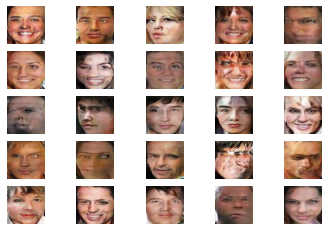

In [13]:
latent_points = generate_latent_points(100, 25)
X  = model.predict(latent_points)
X = (X + 1) / 2.0

plot_generated(X, 5)
save_generated(X)

## Load N number of REAL and GENERATED faces as numpy array

In [14]:
def get_faces(directory, start=0, num=10):
    image_list = []
    file_list = os.listdir(directory)
    file_list.sort()
    for i in range(num):
        if file_list[i+start].endswith(".jpg"):
            image_list.append(directory + file_list[i+start])

    return image_list

In [16]:
num_of_faces = 25

real_faces_directory = "./img_align_celeba/"
real_faces = get_faces(real_faces_directory, 0, num_of_faces)
real_faces = load_images(real_faces)

generated_faces_directory = "./generated_faces/"
generated_faces = get_faces(generated_faces_directory, 0, num_of_faces)
generated_faces = load_images(generated_faces)

In [18]:
fid = calculate_fid(real_faces, generated_faces)
print('Frechet Inception Distance: %.3f' % fid)

Frechet Inception Distance: 296.469


# Compare FID for 2 sub-sets of real faces

In [19]:
real_faces_directory = "./img_align_celeba/"
real_faces1 = get_faces(real_faces_directory, 10, num_of_faces)
real_faces1 = load_images(real_faces1)

real_faces_directory = "./img_align_celeba/"
real_faces2 = get_faces(real_faces_directory, 40, num_of_faces)
real_faces2 = load_images(real_faces2)

fid = calculate_fid(real_faces1, real_faces2)
print('Frechet Inception Distance: %.3f' % fid)

Frechet Inception Distance: 139.367
